## Current Predictions

I want to find some way to update estimates. Perhaps I could do running averages? Or just use last month's estimates as a representation of this months? 

Monthly links on this page are updated every month, but it won't contain current month. https://www.esrl.noaa.gov/psd/data/gridded/data.ncep.reanalysis.surface.html

In [1]:
# import modules
import pandas as pd
import numpy as np
from datetime import datetime
# import dataset from netCDF as nc_open; array storage system
import netCDF4 as nc
# import dataset
from netCDF4 import Dataset 
# interpolate griddate
from scipy import interpolate

# sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

# import picle to save model
import pickle

%matplotlib inline
import matplotlib as plt
import seaborn as sns

Set grid for new climate predictors.

In [2]:
# custom grids for every degree
# vectors
grid_lat = np.arange(24, 50.0, 1)
grid_lon = np.arange(-125.0, -66, 1)
# mesh grid array
glons, glats = np.meshgrid(grid_lon, grid_lat)
# coordinates to a 2 dimension array
us_grid = np.array(np.meshgrid(grid_lon, grid_lat)).reshape(2, -1).T

# create grid id array
grid_id = np.arange(1, 1535,1)
grid_id_array = np.reshape(grid_id, (26,59))
grid_id_flat = grid_id_array.flatten()
# create grid id 1 to 1534 and save as type string
grid_id = pd.DataFrame(grid_id_flat)
grid_id.columns = ['grid_id'] 


# create grid dataframe from coordinate array
grid_df = pd.DataFrame(data = us_grid)
# name columns
grid_df.columns = ['glon', 'glat']
# concat dataframes
grid_df = pd.concat([grid_id, grid_df], axis=1)
# view first rows
grid_df.head()

,grid_id,glon,glat
0,1,-125.0,24.0
1,2,-124.0,24.0
2,3,-123.0,24.0
3,4,-122.0,24.0
4,5,-121.0,24.0


In [48]:
# write grid df columns
#grid_df.to_csv('../data/model_data/grid_coords.csv')

## Current Climate Estimates

### Temperature

In [3]:
temp_nc = Dataset("../data/nc/air.mon.mean.nc")

In [4]:
# extract latitude
lat = temp_nc.variables['lat'][16:26]
# extract longitude
lon = temp_nc.variables['lon'][94:118]-360
# extract time
time = temp_nc.variables['time'][833:846]
# 1st temperature values
temp = temp_nc.variables['air'][833:846,16:26,94:118]
# check dimension of shape
np.shape(temp)

(13, 10, 24)

In [5]:
print(np.min(lat), np.max(lat), np.min(lon)-360, np.max(lon)-360)

27.5 50.0 -485.0 -427.5


In [6]:
print(temp_nc)
# print out details of each variable
for v in temp_nc.variables:
    print(temp_nc.variables[v])

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4_CLASSIC data model, file format HDF5):
    description: Data from NCEP initialized reanalysis (4x/day).  These are the 0.9950 sigma level values
    platform: Model
    Conventions: COARDS
    NCO: 20121012
    history: Thu May  4 20:11:16 2000: ncrcat -d time,0,623 /Datasets/ncep.reanalysis.derived/surface/air.mon.mean.nc air.mon.mean.nc
Thu May  4 18:11:50 2000: ncrcat -d time,0,622 /Datasets/ncep.reanalysis.derived/surface/air.mon.mean.nc ./surface/air.mon.mean.nc
Mon Jul  5 23:47:18 1999: ncrcat ./air.mon.mean.nc /Datasets/ncep.reanalysis.derived/surface/air.mon.mean.nc /dm/dmwork/nmc.rean.ingest/combinedMMs/surface/air.mon.mean.nc
/home/hoop/crdc/cpreanjuke2farm/cpreanjuke2farm Mon Oct 23 21:04:20 1995 from air.sfc.gauss.85.nc
created 95/03/13 by Hoop (netCDF2.3)
Converted to chunked, deflated non-packed NetCDF4 2014/09
    title: monthly mean air.sig995 from the NCEP Reanalysis
    References: http://www.esrl.noaa.gov/psd/dat

In [7]:
temp.shape

(13, 10, 24)

In [8]:
# create empty numpy array of 843 days and 23 lon by 55 lat 
temp_fine = np.zeros((13, 26, 59))

# interpolate for each month to new grid
for i in range(13):
    # extract temp element
    temp_mon = temp[i]
    # create interpolate 
    interp_spline = interpolate.RectBivariateSpline(sorted(lat), lon, temp_mon)
    # interpolate to new grid
    temp_fine[i] = interp_spline(grid_lat, grid_lon)

In [9]:
# read grid id to subset
us_grid_id = (pd.read_csv('../data/model_data/us_grid_id.csv', index_col = 0)
              .groupby('grid_id').count().reset_index())
# unique

In [10]:
us_grid_id.head()

,grid_id
0,163
1,204
2,205
3,221
4,222


In [11]:
# extract temp grid as a 843 by n matrix
us_temp = temp_fine.reshape(13,1534).T #.T is for transpose
# pandas df
temp_df = pd.DataFrame(data = us_temp)
# extract date times from nc file; define units
date = nc.num2date(time, 'hours since 1800-01-01 00:00:0.0')
# ts
ts = pd.Series(date, index = date)
# view first couple observations
ts.head()
# add name
temp_df.columns = ts.dt.date
# concat
temp_wide_df = pd.concat([grid_df, temp_df], axis = 1)
# wide to long
temp_long_df = pd.melt(temp_wide_df, id_vars = ['grid_id', 'glon', 'glat'],
                      var_name = "date", value_name = "temp_c")

# lag for a year
number_lags = 12

for lag in range(1, number_lags + 1):
    temp_long_df['temp_c_lag' + str(lag)] = temp_long_df.groupby('grid_id')['temp_c'].shift(lag)

# convert temp to datetime
temp_long_df['date'] = pd.to_datetime(temp_long_df['date'])
# filter to only 2018-06-01
temp_pred = temp_long_df[temp_long_df['date'] == '2018-06-01']
## filter to only grid ids in the states
temp_pred = temp_pred.merge(us_grid_id,  on = 'grid_id', how = 'inner')

In [12]:
temp_pred.shape

(819, 17)

### Precipitation 

In [13]:
prec_nc = Dataset("../data/nc/pr_wtr.mon.mean.nc")
# extract latitude
lat = prec_nc.variables['lat'][16:26]
# extract longitude
lon = prec_nc.variables['lon'][94:118]-360
# extract time
time = prec_nc.variables['time'][833:846]
# 1st precerature values
prec = prec_nc.variables['pr_wtr'][833:846,16:26,94:118]
# check dimension of shape
np.shape(prec)

(13, 10, 24)

In [14]:
# create empty numpy array of 843 days and 23 lon by 55 lat 
prec_fine = np.zeros((13, 26, 59))

# interpolate for each month to new grid
for i in range(13):
    # extract prec element
    prec_mon = prec[i]
    # create interpolate 
    interp_spline = interpolate.RectBivariateSpline(sorted(lat), lon, prec_mon)
    # interpolate to new grid
    prec_fine[i] = interp_spline(grid_lat, grid_lon)

In [15]:
# extract prec grid as a 843 by n matrix
us_prec = prec_fine.reshape(13,1534).T #.T is for transpose
# pandas df
prec_df = pd.DataFrame(data = us_prec)
# extract date times from nc file; define units
date = nc.num2date(time, 'hours since 1800-01-01 00:00:0.0')
# ts
ts = pd.Series(date, index = date)
# view first couple observations
ts.head()
# add name
prec_df.columns = ts.dt.date
# concat
prec_wide_df = pd.concat([grid_df, prec_df], axis = 1)
# wide to long
prec_long_df = pd.melt(prec_wide_df, id_vars = ['grid_id', 'glon', 'glat'],
                      var_name = "date", value_name = "prec_kgm2")

# lag for a year
number_lags = 12

for lag in range(1, number_lags + 1):
    prec_long_df['prec_kgm2_lag' + str(lag)] = prec_long_df.groupby('grid_id')['prec_kgm2'].shift(lag)

# convert prec to datetime
prec_long_df['date'] = pd.to_datetime(prec_long_df['date'])
# filter to only 2018-06-01
prec_pred = prec_long_df[prec_long_df['date'] == '2018-06-01']
# filter to only grid ids in the states
prec_pred = prec_pred.merge(us_grid_id,  on = 'grid_id', how = 'inner')

In [16]:
del prec_long_df
del prec_wide_df

### Humidity

In [17]:
rhum_nc = Dataset("../data/nc/rhum.mon.mean.nc")
# extract latitude
lat = rhum_nc.variables['lat'][16:26]
# extract longitude
lon = rhum_nc.variables['lon'][94:118]-360
# extract time
time = rhum_nc.variables['time'][833:846]
# 1st rhumerature values
rhum = rhum_nc.variables['rhum'][833:846,16:26,94:118]
# check dimension of shape
np.shape(rhum)

(13, 10, 24)

In [18]:
# create empty numpy array of 843 days and 23 lon by 55 lat 
rhum_fine = np.zeros((13, 26, 59))

# interpolate for each month to new grid
for i in range(13):
    # extract rhum element
    rhum_mon = rhum[i]
    # create interpolate 
    interp_spline = interpolate.RectBivariateSpline(sorted(lat), lon, rhum_mon)
    # interpolate to new grid
    rhum_fine[i] = interp_spline(grid_lat, grid_lon)

In [19]:
# extract rhum grid as a 843 by n matrix
us_rhum = rhum_fine.reshape(13,1534).T #.T is for transpose
# pandas df
rhum_df = pd.DataFrame(data = us_rhum)
# extract date times from nc file; define units
date = nc.num2date(time, 'hours since 1800-01-01 00:00:0.0')
# ts
ts = pd.Series(date, index = date)
# view first couple observations
ts.head()
# add name
rhum_df.columns = ts.dt.date
# concat
rhum_wide_df = pd.concat([grid_df, rhum_df], axis = 1)
# wide to long
rhum_long_df = pd.melt(rhum_wide_df, id_vars = ['grid_id', 'glon', 'glat'],
                      var_name = "date", value_name = "rhum_perc")

# lag for a year
number_lags = 12

for lag in range(1, number_lags + 1):
    rhum_long_df['rhum_perc_lag' + str(lag)] = rhum_long_df.groupby('grid_id')['rhum_perc'].shift(lag)

# convert rhum to datetime
rhum_long_df['date'] = pd.to_datetime(rhum_long_df['date'])
# filter to only 2018-06-01
rhum_pred = rhum_long_df[rhum_long_df['date'] == '2018-06-01']
# filter to only grid ids in the states
rhum_pred = rhum_pred.merge(us_grid_id,  on = 'grid_id', how = 'inner')

In [20]:
del rhum_long_df
del rhum_wide_df

### Merge Predictors

In [21]:
prec_pred.head()

,grid_id,glon,glat,date,prec_kgm2,prec_kgm2_lag1,prec_kgm2_lag2,prec_kgm2_lag3,prec_kgm2_lag4,prec_kgm2_lag5,prec_kgm2_lag6,prec_kgm2_lag7,prec_kgm2_lag8,prec_kgm2_lag9,prec_kgm2_lag10,prec_kgm2_lag11,prec_kgm2_lag12
0,163,-81.0,26.0,2018-06-01,20.478003,15.449573,5.341585,4.382809,3.679564,4.269675,3.892343,6.871578,15.769510,22.612191,21.770089,21.167732,20.094990
1,204,-99.0,27.0,2018-06-01,25.379827,18.585682,7.051675,6.727160,3.176232,6.044901,5.471800,7.843397,12.020979,19.257735,21.250598,24.800062,21.020655
2,205,-98.0,27.0,2018-06-01,25.837522,18.862654,7.066830,6.740320,3.340907,6.020666,5.393337,7.862224,12.301051,19.870039,21.458303,25.153453,21.736515
3,221,-82.0,27.0,2018-06-01,20.622429,15.760715,5.153669,4.140541,3.575913,4.293995,3.864924,6.807694,15.502593,22.712871,21.603004,21.123772,19.982547
4,222,-81.0,27.0,2018-06-01,20.478003,15.449573,5.341585,4.382809,3.679564,4.269675,3.892343,6.871578,15.769510,22.612191,21.770089,21.167732,20.094990


In [22]:
temp_pred.dtypes

grid_id                  int64
glon                   float64
glat                   float64
date            datetime64[ns]
temp_c                 float64
temp_c_lag1            float64
temp_c_lag2            float64
temp_c_lag3            float64
temp_c_lag4            float64
temp_c_lag5            float64
temp_c_lag6            float64
temp_c_lag7            float64
temp_c_lag8            float64
temp_c_lag9            float64
temp_c_lag10           float64
temp_c_lag11           float64
temp_c_lag12           float64
dtype: object

In [23]:
temp_pred.shape

(819, 17)

In [24]:
# merge climate predictor
climate_pred = temp_pred.merge(prec_pred, on=['grid_id', 'glon', 'glat', 'date'], 
                               how = 'left')
# merge rhum
climate_pred = climate_pred.merge(rhum_pred, on=['grid_id', 'glon', 'glat', 'date'], 
                               how = 'left')
# remove date and grid id since those aren't in the predictive model
climate_vars = climate_pred.loc[:, 'glon':'rhum_perc_lag12']
climate_vars = climate_vars.drop(['date'], axis =1)

In [25]:
# head climate_pred
climate_vars.head()

,glon,glat,temp_c,temp_c_lag1,temp_c_lag2,temp_c_lag3,temp_c_lag4,temp_c_lag5,temp_c_lag6,temp_c_lag7,...,rhum_perc_lag3,rhum_perc_lag4,rhum_perc_lag5,rhum_perc_lag6,rhum_perc_lag7,rhum_perc_lag8,rhum_perc_lag9,rhum_perc_lag10,rhum_perc_lag11,rhum_perc_lag12
0,-81.0,26.0,12.521540,5.362404,-5.969960,-10.519196,-15.299948,-18.379017,-17.292096,-7.064471,...,80.360573,79.313362,78.814968,81.889078,86.662634,84.991889,83.440095,80.681789,81.018254,93.094906
1,-99.0,27.0,19.046893,13.698112,0.093025,-4.714527,-16.368731,-13.821523,-11.784078,-6.150223,...,91.923576,92.955540,93.636358,91.049788,92.488513,70.276452,70.386472,58.450864,64.771793,78.118425
2,-98.0,27.0,19.062270,13.521303,0.021448,-4.764079,-16.134814,-14.300763,-12.235255,-6.321454,...,91.347976,93.041386,93.241208,91.272632,92.831888,72.257736,72.547689,60.922151,67.588631,81.070852
3,-82.0,27.0,12.495797,5.777090,-5.992146,-10.829189,-15.417930,-18.193560,-17.276909,-7.231200,...,78.397386,77.704508,78.276857,81.790219,86.810282,84.883678,83.340885,79.895493,80.691748,93.452944
4,-81.0,27.0,12.521540,5.362404,-5.969960,-10.519196,-15.299948,-18.379017,-17.292096,-7.064471,...,80.360573,79.313362,78.814968,81.889078,86.662634,84.991889,83.440095,80.681789,81.018254,93.094906


### Current Estimate Using Logistic Predictive Model

In [26]:
# load logistic model
log_mod = pickle.load(open('../data/model_data/log_pred_mod.sav', 'rb'))

In [27]:
# current fire predictions for grid cells
fire_pred = log_mod.predict_proba(climate_vars)

In [28]:
# extract probability of fire for each grid
pr_fire = []
for l, i in enumerate(fire_pred):
    pr_fire.append(i[1])
    
# grid ids to list; should be in same order
grid_id_list = us_grid_id['grid_id'].tolist()

# set in pandas dataframe
pr_fires = pd.DataFrame(np.column_stack([grid_id_list, pr_fire]), 
                               columns=['grid_id', 'pr_fire'])

# merge two different dataframes
grid_pr_fires = pd.merge(grid_df, pr_fires, on='grid_id', how = 'left')
grid_heatmap = pd.merge(grid_df, pr_fires, on='grid_id', how = 'right')

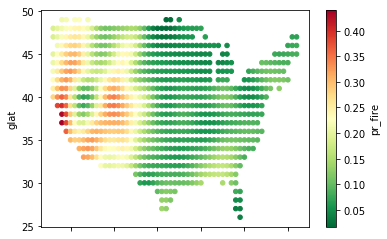

In [29]:
# simple pandas plot
grid_pr_fires.plot.scatter(x='glon',y='glat', c='pr_fire', 
                           colormap = 'RdYlGn_r')

In [30]:
# sort grid_pr fires by lat/lon to get projection right
fpr_a = (grid_pr_fires.sort_values(['glat', 'glon'], ascending=[False,True])['pr_fire']
         .values.reshape(26,59))

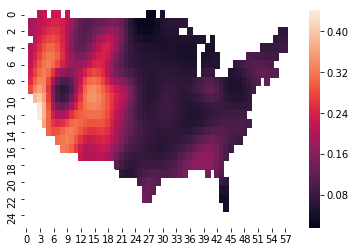

In [31]:
# plot heatmap of predicted probability for fires
import seaborn as sns
sns.heatmap(fpr_a)

### Folium Map

Currently not working. 

In [32]:
# loading folium
import folium
from folium import plugins

In [33]:
grid_heatmap.head()

,grid_id,glon,glat,pr_fire
0,163,-81.0,26.0,0.037078
1,204,-99.0,27.0,0.137523
2,205,-98.0,27.0,0.129145
3,221,-82.0,27.0,0.034210
4,222,-81.0,27.0,0.035872


In [34]:
# extract matrix for fire heatmap
hm_sub = grid_heatmap[grid_heatmap['pr_fire'] >= 0.25]
fire_hm = hm_sub[['glat', 'glon', 'pr_fire']].values

In [35]:
hm_sub.shape

(126, 4)

In [36]:
# extract lat, lon, and magnitude for the folium heatmap
lats = [float(item[0]) for item in fire_hm]
lons = [float(item[1]) for item in fire_hm]
fpr = [float(item[2]) for item in fire_hm]

In [37]:
# Using USGS style tile
url_base = 'http://server.arcgisonline.com/ArcGIS/rest/services/'
service = 'NatGeo_World_Map/MapServer/tile/{z}/{y}/{x}'
tileset = url_base + service

m = folium.Map(location=[34, -96], zoom_start=4,\
                control_scale = True, tiles=tileset, attr='USGS style')

# mark each station as a point
for index, row in hm_sub.iterrows():
    folium.CircleMarker([row['glat'], row['glon']],
                        radius=15,
                        fill=True, # Set fill to True
                        fill_color=row['pr_fire'],
                       ).add_to(m)
    
# add heatmap
m.add_child(plugins.HeatMap(zip(lats,lons,fpr), radius = 10))

## Size Prediction

In [38]:
# load random forest classifier
rf = pickle.load(open('../data/model_data/size_mod.sav', 'rb'))

In [39]:
# predict fire size
size_pred = rf.predict(climate_vars)

In [40]:
# extract predicted fire class 
pr_size = []
for i in enumerate(size_pred):
    pr_size.append(i[1])
    
# grid ids to list; should be in same order
grid_id_list = us_grid_id['grid_id'].tolist()

# set in pandas dataframe
pr_size = pd.DataFrame(np.column_stack([grid_id_list, pr_size]), 
                               columns=['grid_id', 'pr_size'])

# convert grid id pr_size to int
pr_size['grid_id'] = pr_size['grid_id'].astype(int)
# add some numeric values for acre size
def sizef(row):
    if row['pr_size'] == 'A':
        return 1.0
    elif row['pr_size'] == 'B':
        return 10.0
    elif row['pr_size'] == 'C':
        return 100.0
    elif row['pr_size'] == 'D':
        return 300.0
    elif row['pr_size'] == 'E':
        return 1000.0
    elif row['pr_size'] == 'F':
        return 2500.0
    elif row['pr_size'] == 'G':
        return 5000.0
    
pr_size['size_val'] = pr_size.apply(sizef, axis=1)
    

# merge two different dataframes
grid_pr_size = pd.merge(grid_df, pr_size, on='grid_id', how = 'left')
grid_heatmap_size = pd.merge(grid_df, pr_size, on='grid_id', how = 'right')

In [41]:
# my fire size model doesn't predict any fires over 100; or size class C. 
# this is a limitation
grid_pr_size.describe()

,grid_id,glon,glat,size_val
count,1534.000000,1534.00000,1534.000000,819.000000
mean,767.500000,-96.00000,36.500000,6.065934
std,442.971971,17.03494,7.502446,12.274491
min,1.000000,-125.00000,24.000000,1.000000
25%,384.250000,-111.00000,30.000000,1.000000
50%,767.500000,-96.00000,36.500000,1.000000
75%,1150.750000,-81.00000,43.000000,10.000000
max,1534.000000,-67.00000,49.000000,100.000000


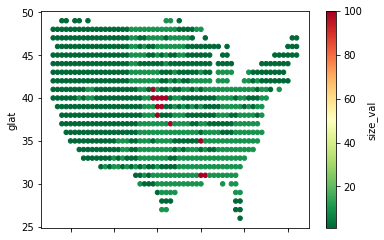

In [42]:
# simple pandas plot
grid_pr_size.plot.scatter(x='glon',y='glat', c='size_val', 
                           colormap = 'RdYlGn_r')

The size model really doesn't work well. I think this will get better with more varaibles like vegetation, and maybe fuel type, and a more sophisticated model. 

I need to build a shiny app I think.

In [47]:
# write as csv files for shiny app
#grid_pr_fires.to_csv('../data/model_data/current_fire_prob.csv')
#grid_pr_size.to_csv('../data/model_data/current_fire_size.csv')